In [1]:
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import ForecastingModel, Forecaster, backtest, eval_crps
from pyro.infer.reparam import LocScaleReparam, StableReparam
from pyro.ops.tensor_utils import periodic_cumsum, periodic_repeat, periodic_features
from pyro.ops.stats import quantile
import matplotlib.pyplot as plt

%matplotlib inline
assert pyro.__version__.startswith('1.8.1')
pyro.set_rng_seed(20200221)

/Users/liyanran/opt/anaconda3/envs/online/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


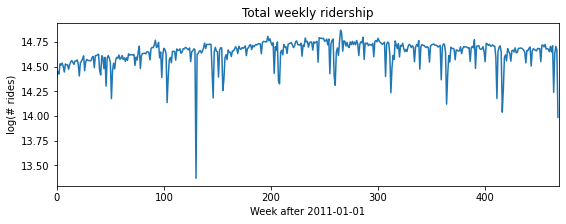

In [3]:
T, O, D = dataset["counts"].shape
data = dataset["counts"][:T // (24 * 7) * 24 * 7].reshape(T // (24 * 7), -1).sum(-1).log()
data = data.unsqueeze(-1)
plt.figure(figsize=(9, 3))
plt.plot(data)
plt.title("Total weekly ridership")
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, len(data));